PROBLEM 7: DBSCAN on real data

Run the DBSCAN algorithm on:

1. 20NG

2. FASHION 

3. HouseHold (see papers), and evaluate results.

You need to implement both phases:
1) Neighborhoods creation

2) DBSCAN

Explain why/when it works, and speculate why/when not. You need to trial and error for parameters epsilon and MinPts

In [1]:
import sklearn
import pandas as pd
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

### FASHION DATASET:

In [17]:
data_fashion = torchvision.datasets.FashionMNIST(root='./fashion', download=True, transform=transforms.ToTensor())
print(data_fashion[0][0])

#truncate to 10000 samples:
data_fashion.data = data_fashion.data[:10000]
data_fashion.targets = data_fashion.targets[:10000]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000,

In [18]:
data_fashion_numpy = data_fashion.data.numpy()
print(data_fashion_numpy[0])
print(len(data_fashion_numpy[0]))

[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   1   0   0  13  73   0
    0   1   4   0   0   0   0   1   1   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3   0  36 136 127  62
   54   0   0   0   1   3   4   0   0   3]
 [  0   0   0   0   0   0   0   0   0   0   0   0   6   0 102 204 176 134
  144 123  23   0   0   0   0  12  10   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0 155 236 207 178
  107 156 161 109  64  23  77 130  72  15]
 [  0   0   0   0   0   0   0   0   0   0   0   1   0  69 207 223 218 216
  216 163 127 121 122 146 141  88 172  66]
 [  0   0   0   0   0   0   0   0   0   1   1   1   0 200 232 23

In [19]:

print(data_fashion.targets)
data_fashion_labels = data_fashion.targets.numpy()[:10000]
# print(data_fashion_labels)

tensor([9, 0, 0,  ..., 0, 6, 6])


In [20]:
# test euclidean distances between the two types (tensors and numpy arrays)
print("Between tensors: ", torch.dist(data_fashion[0][0], data_fashion[1][0]), "using norm: ", torch.norm(data_fashion[0][0] - data_fashion[1][0]), "using numpy: ", np.linalg.norm(data_fashion[0][0].numpy() - data_fashion[1][0].numpy()))
print("Between tensors: ", torch.dist(data_fashion[1][0], data_fashion[2][0]), "using norm: ", torch.norm(data_fashion[1][0] - data_fashion[2][0]), "using numpy: ", np.linalg.norm(data_fashion[1][0].numpy() - data_fashion[2][0].numpy()))
print("Between numpy arrays: ", np.linalg.norm(data_fashion_numpy[1][0] - data_fashion_numpy[2][0]))
print("Between numpy arrays: ", np.linalg.norm(data_fashion_numpy[0][0] - data_fashion_numpy[1][0]))

Between tensors:  tensor(14.6757) using norm:  tensor(14.6757) using numpy:  14.675714
Between tensors:  tensor(11.8889) using norm:  tensor(11.8889) using numpy:  11.888938
Between numpy arrays:  394.31839926637963
Between numpy arrays:  614.6169538826601


In [21]:
# 1. Compute distances, get neighbors:

def euclidean_distance(x, y):
    # Convert tensors to float type
    x = x.float()
    y = y.float()
    return torch.dist(x, y)

def get_neighbors(data, point, epsilon):
    neighbors = []
    # print("point: ", point)
    # print("data: ", data)
    # differing between samples:
    for i in range(len(data)):
        if euclidean_distance(data[i], point) < epsilon:
            neighbors.append(i)
    return neighbors

# 2. DBSCAN algorithm:
def dbscan(df, epsilon, min_points):
    labels = [0] * len(df)
    c = 0
    for i in tqdm(range(len(df))):
        if labels[i] != 0:
            continue
        neighbors = get_neighbors(df, df[i], epsilon)
        if len(neighbors) < min_points:
            labels[i] = -1
            continue
        c += 1
        labels[i] = c
        for j in neighbors:
            if labels[j] == -1:
                labels[j] = c
            if labels[j] != 0:
                continue
            labels[j] = c
            new_neighbors = get_neighbors(df, df[j], epsilon)
            if len(new_neighbors) >= min_points:
                neighbors.extend(new_neighbors)
    return labels



In [28]:
# to find best epsilon:
neighbors = get_neighbors(data_fashion.data, data_fashion.data[1], 1600)
neighbors = sorted(neighbors)
print("neighbors: ", neighbors)
print(len(neighbors))
print("labels: ", data_fashion.targets[neighbors])

# print counts of neighbors
unique, counts = np.unique(data_fashion.targets[neighbors], return_counts=True)
print("unique: ", unique)
print("counts: ", counts)

neighbors:  [1, 48, 55, 66, 154, 171, 176, 272, 331, 519, 641, 665, 741, 816, 823, 877, 967, 1041, 1169, 1264, 1526, 1897, 2058, 2238, 2289, 2300, 2303, 2374, 2423, 2439, 2582, 2698, 2741, 2795, 2944, 3048, 3205, 3227, 3340, 3470, 3485, 3533, 3592, 3637, 3717, 3743, 3745, 3759, 3874, 3946, 3968, 3992, 4125, 4363, 4455, 4581, 4718, 4724, 4835, 4853, 4947, 5200, 5365, 5473, 5480, 5485, 5733, 5737, 5743, 5792, 5803, 5894, 6106, 6165, 6217, 6322, 6366, 6410, 6488, 6787, 7010, 7064, 7129, 7263, 7306, 7374, 7403, 7457, 7499, 7534, 7606, 7680, 7939, 7944, 8030, 8056, 8108, 8296, 8426, 8590, 8600, 8743, 8822, 8850, 8945, 9102, 9197, 9248, 9437, 9571, 9685, 9715, 9775, 9981]
114
labels:  tensor([0, 0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6, 0, 0, 0, 0, 0, 0,
        0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [29]:
# to find best epsilon:
neighbors = get_neighbors(data_fashion.data, data_fashion.data[1], 2000)
neighbors = sorted(neighbors)
print("neighbors: ", neighbors)
print(len(neighbors))
print("labels: ", data_fashion.targets[neighbors])

# print counts of neighbors
unique, counts = np.unique(data_fashion.targets[neighbors], return_counts=True)
print("unique: ", unique)
print("counts: ", counts)

neighbors:  [1, 10, 17, 48, 55, 66, 149, 154, 171, 176, 191, 219, 225, 237, 272, 304, 321, 329, 331, 338, 410, 415, 441, 448, 519, 524, 549, 564, 565, 595, 641, 665, 716, 732, 741, 745, 748, 771, 780, 789, 812, 815, 816, 823, 829, 839, 877, 880, 893, 905, 965, 967, 1013, 1041, 1056, 1073, 1078, 1119, 1142, 1169, 1228, 1264, 1288, 1303, 1311, 1327, 1410, 1424, 1460, 1516, 1526, 1599, 1600, 1603, 1608, 1622, 1647, 1682, 1731, 1737, 1745, 1790, 1791, 1837, 1843, 1846, 1849, 1850, 1861, 1897, 1912, 1929, 1942, 1950, 1979, 1989, 2012, 2027, 2041, 2058, 2060, 2078, 2127, 2133, 2159, 2202, 2238, 2267, 2286, 2289, 2300, 2303, 2315, 2350, 2367, 2374, 2389, 2405, 2423, 2433, 2439, 2446, 2479, 2492, 2582, 2601, 2695, 2698, 2741, 2745, 2795, 2832, 2911, 2944, 2962, 2994, 3048, 3050, 3154, 3205, 3227, 3237, 3270, 3298, 3325, 3326, 3333, 3340, 3373, 3379, 3470, 3472, 3485, 3533, 3534, 3592, 3620, 3637, 3655, 3667, 3679, 3686, 3717, 3743, 3745, 3759, 3767, 3815, 3865, 3874, 3897, 3922, 3938, 3946, 39

In [ ]:
# count of labels:
unique, counts = np.unique(data_fashion.targets, return_counts=True)
print("unique: ", unique)
print("counts: ", counts)

unique:  [0 1 2 3 4 5 6 7 8 9]
counts:  [ 942 1027 1016 1019  974  989 1021 1022  990 1000]


In [30]:
# example distance between two points of the same class
print(data_fashion_labels[:10])
print("Dist within a cluster: ", euclidean_distance(data_fashion.data[1], data_fashion.data[2]))
print(data_fashion.targets[1], data_fashion.targets[2])
print("Dist between two different clusters: ", euclidean_distance(data_fashion.data[0], data_fashion.data[8]))
print(data_fashion.targets[0], data_fashion.targets[8])

[9 0 0 3 0 2 7 2 5 5]
Dist within a cluster:  tensor(3031.6790)
tensor(0) tensor(0)
Dist between two different clusters:  tensor(3495.4448)
tensor(9) tensor(5)


In [ ]:
# pass it: (aim for around 200 in the first cluster) - when using 2000 samples
labels = dbscan(data_fashion.data, 1020, 3)

100%|██████████| 2000/2000 [01:50<00:00, 18.18it/s]


In [ ]:
# pass it: (aim for around 1000 in the first cluster) - when using 10000 samples
labels = dbscan(data_fashion.data, 1600, 3)

In [ ]:
# silhouette score: (for 2000 samples, e = 1020, minpts = 3)
from sklearn.metrics import silhouette_score

# Reshape data to 2D
data_fashion_reshaped = data_fashion.data.view(data_fashion.data.size(0), -1).numpy()
print("Silhouette score: ", silhouette_score(data_fashion_reshaped, labels))

Silhouette score:  -0.2572544970335453


In [ ]:
# 1050,5
clusters = set(labels)
print("Clusters: ", clusters)
print("Counts of clusters: ", {i: list(labels).count(i) for i in clusters})

Clusters:  {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, -1}
Counts of clusters:  {1: 184, 2: 121, 3: 39, 4: 181, 5: 23, 6: 18, 7: 10, 8: 11, 9: 4, 10: 11, 11: 9, 12: 7, 13: 14, 14: 17, 15: 10, 16: 5, 17: 5, 18: 5, 19: 5, -1: 1321}


In [15]:
# afterwards to compare: 1020,3 
clusters = set(labels)
print("Clusters: ", clusters)
print("Counts of clusters: ", {i: list(labels).count(i) for i in clusters})

Clusters:  {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, -1}
Counts of clusters:  {1: 275, 2: 49, 3: 53, 4: 173, 5: 18, 6: 3, 7: 3, 8: 18, 9: 16, 10: 3, 11: 3, 12: 4, 13: 14, 14: 3, 15: 12, 16: 4, 17: 3, 18: 5, 19: 3, 20: 5, 21: 3, 22: 4, 23: 3, 24: 3, 25: 3, 26: 4, 27: 3, 28: 3, 29: 5, -1: 1302}


In [ ]:
# afterwards to compare: 1200, 10
clusters = set(labels)
print("Clusters: ", clusters)
print("Counts of clusters: ", {i: list(labels).count(i) for i in clusters})

Clusters:  {1, 2, -1}
Counts of clusters:  {1: 982, 2: 12, -1: 1006}


In [ ]:
# afterwards to compare: 1000,4
clusters = set(labels)
print("Clusters: ", clusters)
print("Counts of clusters: ", {i: list(labels).count(i) for i in clusters})

Clusters:  {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, -1}
Counts of clusters:  {1: 125, 2: 104, 3: 171, 4: 11, 5: 11, 6: 4, 7: 7, 8: 19, 9: 26, 10: 4, 11: 9, 12: 13, 13: 8, 14: 5, 15: 9, 16: 4, 17: 10, 18: 5, 19: 10, 20: 4, -1: 1441}


In [ ]:
# find optimal min_points by incrementing, optimal epsilon by oscillation

for i in tqdm(range(4,10)):
    labels = dbscan(data_fashion.data, 1020, i)
    clusters = set(labels)
    print("Clusters: ", clusters)
    print("Counts of clusters: ", {i: list(labels).count(i) for i in clusters})
    if(len(clusters) == 10):
        print("Optimal min_points: ", i)
        break
    

  0%|          | 0/6 [00:25<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# pass it: (aim for around 1000 in the first cluster) - when using 10000 samples
labels = dbscan(data_fashion.data, 840, 3)

100%|██████████| 10000/10000 [41:04<00:00,  4.06it/s] 


In [36]:
data_fashion_reshaped = data_fashion.data.view(data_fashion.data.size(0), -1).numpy()
print("Silhouette score: ", silhouette_score(data_fashion_reshaped, labels))

Silhouette score:  -0.37446244181075167


In [37]:
# 10000 samples, 840,3
clusters = set(labels)
print("Clusters: ", clusters)
print("Counts of clusters: ", {i: list(labels).count(i) for i in clusters})

Clusters:  {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, -1}
Counts of clusters:  {1: 953, 2: 6, 3: 4, 4: 751, 5: 138, 6: 19, 7: 16, 8: 30, 9: 4, 10: 23, 11: 5, 12: 22, 13: 15, 14: 15, 15: 10, 16: 3, 17: 13, 18: 50, 19: 21, 20: 8, 21: 14, 22: 11, 23: 16, 24: 5, 25: 4, 26: 3, 27: 3, 28: 7, 29: 9, 30: 7, 31: 4, 32: 5, 33: 6, 34: 37, 35: 6, 36: 13, 37: 11, 38: 7, 39: 6, 40: 7, 41: 5, 42: 8, 43: 5, 44: 3, 45: 4, 46: 5, 47: 3, 48: 8, 49: 6, 50: 3, 51: 8, 52: 4, 53: 3, 54: 5, 55: 3, 56: 8, 57: 3, 58: 9, 59: 7, 60: 3, 61: 9, 62: 5, 63: 5, 64: 3, 65: 3, 66: 4, 67: 3, 68: 3, 69: 3, 70: 4, 71: 3, 72: 3, 73: 3, 74: 3, 75: 3, 76: 6, 77: 3, 78: 3, 79: 3, 80: 4, 81: 3, 82: 3, 83: 3, 84: 4, 85: 3, 86: 3, 87:

In [ ]:
# look at counts of cluster 1:
cluster_1 = [i for i in range(len(labels)) if labels[i] == 1]
print("Cluster 1 indices: ", cluster_1)
print("Labels of cluster 1: ", data_fashion.targets[cluster_1])
# print counts of cluster 1
unique, counts = np.unique(data_fashion.targets[cluster_1], return_counts=True)
print("unique: ", unique)
print("counts: ", counts)

Cluster 1:  [2, 14, 30, 33, 34, 54, 63, 66, 83, 87, 95, 131, 132, 138, 140, 145, 154, 162, 164, 176, 183, 187, 189, 202, 207, 210, 219, 229, 239, 262, 272, 279, 293, 319, 339, 357, 369, 382, 413, 428, 429, 437, 438, 448, 470, 493, 512, 516, 518, 519, 522, 524, 558, 567, 598, 602, 618, 619, 632, 636, 640, 665, 666, 690, 716, 720, 739, 741, 762, 770, 771, 780, 790, 792, 798, 816, 823, 829, 830, 836, 839, 840, 845, 848, 855, 858, 880, 893, 898, 903, 905, 920, 926, 928, 957, 967, 974, 975, 978, 979, 983, 988, 989, 995, 1012, 1039, 1044, 1049, 1054, 1067, 1069, 1071, 1073, 1075, 1084, 1103, 1105, 1109, 1116, 1133, 1138, 1164, 1176, 1179, 1200, 1209, 1210, 1212, 1218, 1224, 1230, 1236, 1240, 1288, 1291, 1297, 1302, 1308, 1318, 1350, 1353, 1354, 1383, 1396, 1424, 1430, 1439, 1449, 1453, 1455, 1471, 1474, 1489, 1505, 1517, 1539, 1543, 1551, 1560, 1570, 1579, 1580, 1585, 1602, 1604, 1608, 1622, 1634, 1682, 1691, 1696, 1697, 1699, 1702, 1723, 1730, 1745, 1746, 1754, 1756, 1786, 1791, 1804, 1809,

## Observations:

When using a subset of the data, I required a much higher epsilon and lower minpts in order to get 


## 20NG


In [48]:
# 20NG dataset
newsgroups = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'))
# newsgroups_data = newsgroups.data[:1000]
# newsgroups_target = newsgroups.target[:1000]
# print(len(newsgroups_data))

newsgroups_data = newsgroups.data[:800]


In [49]:
# 1. Preprocess the text data
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(newsgroups_data)

# print(X.shape)  # (documents, features)
# 2. Convert to numpy array
X = np.array(X.todense())
#print(X.shape)
  # (documents, features)
# print(X.shape)  # (documents, features)


In [50]:
def cosine_similarity(x,y):
    if (np.linalg.norm(x) * np.linalg.norm(y)) == 0:
        return 0
    return np.dot(x, y.T) / (np.linalg.norm(x) * np.linalg.norm(y))

In [51]:
# from sklearn.metrics.pairwise import cosine_similarity

# 3. DBSCAN algorithm

def get_neighbors_text(data, point, epsilon):
    neighbors = []
    # print("point: ", point)
    # print("data: ", data)
    # differing between samples:
    for i in range(len(data)):
        if cosine_similarity(data[i], point) > epsilon:
            neighbors.append(i)
    return neighbors

def dbscan_text(df, epsilon, min_points):
    labels = [0] * len(df)
    c = 0
    for i in tqdm(range(len(df))):
        if labels[i] != 0:
            continue
        neighbors = get_neighbors_text(df, df[i], epsilon)
        if len(neighbors) < min_points:
            labels[i] = -1
            continue
        c += 1
        labels[i] = c
        for j in neighbors:
            if labels[j] == -1:
                labels[j] = c
            if labels[j] != 0:
                continue
            labels[j] = c
            new_neighbors = get_neighbors_text(df, df[j], epsilon)
            if len(new_neighbors) >= min_points:
                neighbors.extend(new_neighbors)
    return labels


In [52]:
print(newsgroups.target[:10])

[ 7  5  0 17 19 13 15 15  5  1]


In [53]:
# test between two points of the same class
print("Cosine similarity across two clusters: ", cosine_similarity(X[18], X[89]))
print(newsgroups.target[18], newsgroups.target[89])
print("Cosine similarity within a cluster: ", cosine_similarity(X[2], X[8]))
print(newsgroups.target[1], newsgroups.target[8])

Cosine similarity across two clusters:  0.09232239806031498
6 4
Cosine similarity within a cluster:  0.0
5 5


In [54]:
# counts of each:
unique, counts = np.unique(newsgroups.target, return_counts=True)
print("Unique targets: ", unique)
print("Counts of each target: ", counts)

Unique targets:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]
Counts of each target:  [319 389 394 392 385 395 390 396 398 397 399 396 393 396 394 398 364 376
 310 251]


In [55]:
# pass it:
labels = dbscan_text(X, 0.15, 3)

print("Labels: ", labels)
clusters = set(labels)
print("Clusters: ", clusters)
print("Counts of clusters: ", {i: list(labels).count(i) for i in clusters})

100%|██████████| 800/800 [02:15<00:00,  5.92it/s]

Labels:  [-1, -1, 1, -1, -1, -1, -1, 1, 1, -1, -1, 22, -1, 15, 2, 3, -1, -1, -1, -1, -1, 4, 5, 6, 3, -1, -1, -1, 7, 8, -1, -1, -1, -1, 24, -1, 4, -1, 9, -1, 10, -1, -1, 22, -1, -1, 6, -1, -1, 11, -1, -1, -1, 7, -1, -1, -1, -1, 12, -1, 13, -1, -1, -1, 18, 12, -1, 14, -1, -1, -1, -1, 4, -1, 9, -1, 12, 21, 11, -1, -1, -1, -1, -1, -1, 4, -1, -1, 15, 3, -1, -1, -1, -1, -1, -1, -1, 3, -1, -1, 3, -1, -1, -1, 9, -1, 4, -1, 6, -1, -1, 9, -1, -1, -1, -1, -1, -1, -1, -1, -1, 9, 14, -1, -1, -1, -1, -1, 3, -1, -1, 8, 7, -1, -1, 26, -1, -1, -1, -1, -1, 6, -1, 16, -1, -1, -1, -1, -1, -1, -1, 9, -1, -1, -1, -1, -1, 17, 4, -1, -1, 5, -1, -1, -1, -1, 3, -1, 18, 19, -1, -1, 1, 9, 9, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 13, 3, -1, -1, -1, -1, -1, 12, 3, -1, -1, -1, 9, -1, 2, 19, -1, -1, -1, -1, 4, -1, -1, -1, 3, -1, -1, -1, 12, -1, -1, -1, 28, 20, 16, -1, -1, 3, -1, -1, -1, -1, -1, 4, 5, 21, -1, -1, -1, 9, -1, -1, -1, 16, -1, -1, -1, -1, 6, -1, -1, -1, -1, -1, -1, -1, 9, 28, -1, -1, 21, -1, 4, -1, 

In [56]:
data_fashion_reshaped = X
print("Silhouette score: ", silhouette_score(data_fashion_reshaped, labels))

Silhouette score:  0.008274488025566747


In [57]:
# pass it:
labels = dbscan_text(X, 0.132, 4)

print("Labels: ", labels)
clusters = set(labels)
print("Clusters: ", clusters)
print("Counts of clusters: ", {i: list(labels).count(i) for i in clusters})

100%|██████████| 800/800 [02:16<00:00,  5.88it/s]

Labels:  [-1, -1, 1, -1, -1, -1, -1, 1, 1, 7, 1, 7, -1, 1, 1, 1, 11, -1, -1, -1, -1, 5, 2, 3, 1, -1, -1, -1, 4, 5, -1, -1, -1, -1, -1, 13, 5, -1, 1, -1, 6, -1, 5, 7, -1, -1, 3, -1, -1, 1, -1, -1, -1, 4, -1, -1, -1, -1, 1, -1, -1, 5, -1, -1, 1, 1, -1, -1, -1, -1, -1, -1, 5, 1, 1, -1, 1, 8, 1, -1, 1, -1, -1, -1, -1, 5, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, 1, -1, 5, -1, 3, -1, -1, 1, -1, -1, -1, -1, 5, -1, -1, -1, -1, 1, 1, -1, -1, -1, 1, -1, 1, -1, -1, -1, 4, -1, -1, 13, 1, -1, -1, 5, -1, 3, 8, 4, -1, -1, -1, -1, -1, -1, -1, 1, -1, 14, -1, -1, -1, 11, 5, -1, -1, 2, -1, 1, -1, -1, 1, -1, 1, 8, -1, -1, 1, 1, 1, -1, 5, -1, -1, -1, 1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, -1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 8, 1, 10, -1, -1, 5, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, 9, 1, 4, -1, -1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 4, -1, 10, -1, -1, 3, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, 8, -1, 5, -1, -1, 1, -1, -1, -1, 7, -1, 7, -1, -1, -1,

In [58]:
data_fashion_reshaped = X
print("Silhouette score: ", silhouette_score(data_fashion_reshaped, labels))

Silhouette score:  0.007047705422356454


In [59]:
# pass it:
labels = dbscan_text(X, 0.125, 4)

print("Labels: ", labels)
clusters = set(labels)
print("Clusters: ", clusters)
print("Counts of clusters: ", {i: list(labels).count(i) for i in clusters})

100%|██████████| 800/800 [02:22<00:00,  5.63it/s]

Labels:  [-1, -1, 1, -1, -1, -1, -1, 1, 1, 6, 1, 6, -1, 1, 1, 1, 9, 1, -1, -1, -1, 1, 2, 3, 1, 1, -1, -1, 4, 1, -1, -1, -1, -1, -1, 1, 1, -1, 1, -1, 5, -1, 1, 6, -1, -1, 3, 1, -1, 1, -1, -1, -1, 4, -1, -1, -1, 1, 1, -1, -1, 1, -1, -1, 1, 1, 1, 1, -1, 1, -1, -1, 1, 1, 1, -1, 1, 1, 1, -1, 1, -1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, 1, -1, -1, 1, -1, -1, -1, 1, -1, 1, -1, 3, -1, -1, 1, -1, -1, -1, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, -1, 1, -1, 1, -1, -1, 1, 4, -1, -1, 1, 1, -1, 1, 1, -1, 3, 1, 4, -1, -1, -1, -1, -1, -1, -1, 1, -1, 10, -1, -1, -1, 9, 1, -1, -1, 2, -1, 1, -1, -1, 1, -1, 1, 1, -1, -1, 1, 1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -1, 6, 1, -1, 1, -1, -1, -1, -1, -1, 1, 1, 1, 1, -1, 1, -1, 1, 1, 1, 8, -1, -1, 1, -1, -1, -1, 1, -1, -1, -1, 1, 1, -1, -1, 7, 1, 4, -1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, 1, -1, -1, -1, 4, -1, 8, -1, -1, 3, -1, -1, -1, -1, -1, -1, 1, 1, 1, -1, -1, 1, -1, 1, -1, -1, 1, 1, -1, -1, 6, -1, 6, -1, 1, -1, -1, -1, -1, 1, -1, -1

In [60]:
# silhouette score:

# Reshape data to 2D
data_fashion_reshaped = X
print("Silhouette score: ", silhouette_score(data_fashion_reshaped, labels))

Silhouette score:  0.004809472206711245


## Household

In [68]:
# Household dataset
household_df = pd.read_csv('household_power_consumption.txt', sep=';', low_memory=False)
household_df= household_df.dropna()
household_df.drop(columns=['Date', 'Time'], inplace=True)
household_df = household_df.astype(float)
print(household_df.head())

# truncate to 1000 samples:

household_df = household_df[:3000]

   Global_active_power  Global_reactive_power  Voltage  Global_intensity  \
0                4.216                  0.418   234.84              18.4   
1                5.360                  0.436   233.63              23.0   
2                5.374                  0.498   233.29              23.0   
3                5.388                  0.502   233.74              23.0   
4                3.666                  0.528   235.68              15.8   

   Sub_metering_1  Sub_metering_2  Sub_metering_3  
0             0.0             1.0            17.0  
1             0.0             1.0            16.0  
2             0.0             2.0            17.0  
3             0.0             1.0            17.0  
4             0.0             1.0            17.0  


In [69]:
# Execute, point by point, the DBSCAN algorithm

# 1. Compute distances, get neighbors:

def euclidean_distance(x, y):
    return np.linalg.norm(x - y)

def get_neighbors_household(df, point, epsilon):
    neighbors = []
    for i in range(len(df)):
        if euclidean_distance(df.iloc[i], point) < epsilon:
            neighbors.append(i)
    return neighbors

def dbscan_household(df, epsilon, min_points):
    labels = [0] * len(df)
    c = 0
    for i in tqdm(range(len(df))):
        if labels[i] != 0:
            continue
        neighbors = get_neighbors_household(df, df.iloc[i], epsilon)
        if len(neighbors) < min_points:
            labels[i] = -1
            continue
        c += 1
        labels[i] = c
        for j in neighbors:
            if labels[j] == -1:
                labels[j] = c
            if labels[j] != 0:
                continue
            labels[j] = c
            new_neighbors = get_neighbors_household(df, df.iloc[j], epsilon)
            if len(new_neighbors) >= min_points:
                neighbors.extend(new_neighbors)
    return labels


In [70]:
euclidean_distance(household_df.iloc[1], household_df.iloc[2])

np.float64(1.4558983480998946)

In [71]:
labels = dbscan_household(household_df, 1, 25)

100%|██████████| 3000/3000 [10:25<00:00,  4.80it/s]  


In [75]:
unique_labels = set(labels)
print("Unique labels: ", unique_labels)
counts = {i: list(labels).count(i) for i in unique_labels}

Unique labels:  {1, 2, 3, 4, 5, 6, 7, 8, 9, -1}


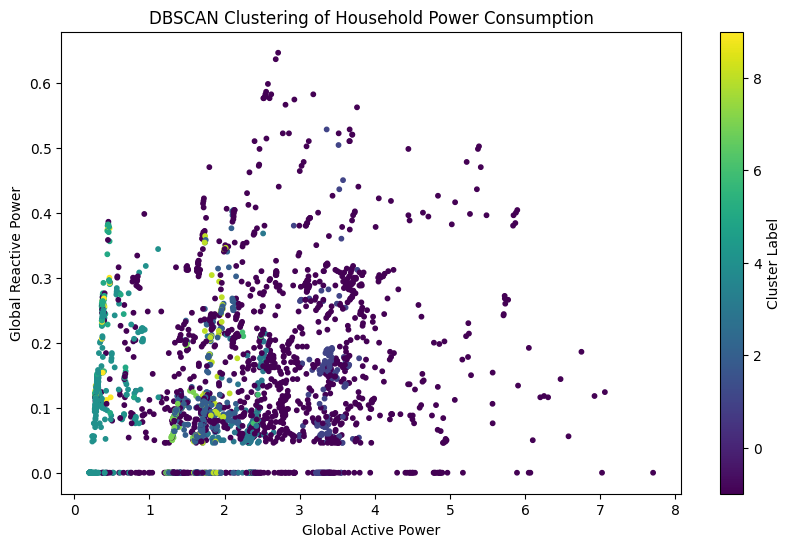

In [76]:
# 2. Plot the results
plt.figure(figsize=(10, 6))
plt.scatter(household_df['Global_active_power'], household_df['Global_reactive_power'], c=labels, cmap='viridis', s=10)
plt.title('DBSCAN Clustering of Household Power Consumption')
plt.xlabel('Global Active Power')
plt.ylabel('Global Reactive Power')
plt.colorbar(label='Cluster Label')
plt.show()


In [77]:
# Silhouette score
from sklearn.metrics import silhouette_score

# Calculate silhouette score
silhouette_avg = silhouette_score(household_df, labels)
print(f'Silhouette Score: {silhouette_avg}')


Silhouette Score: -0.21622102076642893
